In [212]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('export/table_imdb_paris.csv', delimiter=',', on_bad_lines='skip')

dataset.head(1)

,titre,réalisateur,producteur,postal,debut,fin,latitude,longitude,imdb_search,title,date,parental_advisor,duree,genre,imdb_note,metascore,vote,resume
0,TOUT S'EST BIEN PASSE,Francois OZON,MANDARIN PRODUCTION,75013,2020-08-20,2020-08-21,48.83566,2.348315,https://www.imdb.com/search/title/?title=TOUT+...,Everything Went Fine,2021,Tous publics,113.0,Drama,6.8,67.0,1572.0,"When André, 85, has a stroke, Emmanuelle hurri..."


In [213]:
dataset["debut"] = pd.to_datetime( dataset["debut"], format='%Y-%m-%d')
dataset["fin"] = pd.to_datetime( dataset["fin"], format='%Y-%m-%d')
dataset["postal"] = dataset["postal"].astype(str)

In [214]:
# dataset.dtypes
dataset = dataset.reindex(columns = [col for col in dataset.columns if col != 'imdb_note'] + ['imdb_note'])

## Graph de correlation 

In [215]:
dataset = dataset.drop(columns= ['titre', 'réalisateur', 'producteur', 'imdb_search', 'title', 'resume'])

# Correlation matrix
corr_matrix = dataset.corr()

import plotly.figure_factory as ff

corr_matrix = round(dataset.corr(), 4)

# https://plotly.github.io/plotly.py-docs/generated/plotly.figure_factory.create_annotated_heatmap.html
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )


fig.show()

In [216]:
import plotly.express as px
import numpy as np

fig = px.imshow(corr_matrix)
fig.show()

In [217]:
dataset.head(1)

,postal,debut,fin,latitude,longitude,date,parental_advisor,duree,genre,metascore,vote,imdb_note
0,75013,2020-08-20,2020-08-21,48.83566,2.348315,2021,Tous publics,113.0,Drama,67.0,1572.0,6.8


In [218]:
pourcentage_valeur_manquante = 100*dataset.isnull().sum()/dataset.shape[0]

pourcentage_valeur_manquante

postal               0.000000
debut                0.000000
fin                  0.000000
latitude             0.000000
longitude            0.000000
date                 0.000000
parental_advisor    28.389831
duree               11.207627
genre                1.186441
metascore           78.516949
vote                17.394068
imdb_note           17.394068
dtype: float64

## Separation Varibles / Target

In [219]:
target_name = 'imdb_note'

dataset = dataset.dropna(subset=[target_name]).reset_index()

## Separation valeurs explicative et valeur cible
Y = dataset[:][target_name]
X = dataset.drop(columns= [target_name])

## Separation en train/test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)
# stratify = Y # option pour même ratio de réponse que sur la table Y.

In [220]:
pourcentage_valeur_manquante = 100*dataset.isnull().sum()/dataset.shape[0]

pourcentage_valeur_manquante

index                0.000000
postal               0.000000
debut                0.000000
fin                  0.000000
latitude             0.000000
longitude            0.000000
date                 0.000000
parental_advisor    13.567581
duree                3.000769
genre                0.000000
metascore           73.993332
vote                 0.000000
imdb_note            0.000000
dtype: float64

## Pipeline Préprocessor 

In [221]:
## Médiane quantitative & plus fréquent qualitatif

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import( OneHotEncoder, StandardScaler, LabelEncoder )
from sklearn.compose import ColumnTransformer

# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur


In [222]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # Train Model 

## Training

In [223]:
model.fit(X_train, Y_train) # Training is always done on train set !!

LinearRegression()

## Prediction

In [224]:
Y_train_pred = model.predict(X_train) # Predictions on training set
Y_test_pred = model.predict(X_test) # Prédictions on test set 

## R2 Score
__Quantitatif (Numérique)__

In [225]:
from sklearn.metrics import r2_score

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.6709862420738489
R2 score on test set :  0.6123289418851372


## Classement valeurs explicatives

Feature: 0, Score: -0.01582
Feature: 1, Score: 0.05449
Feature: 2, Score: 0.07182
Feature: 3, Score: 0.26083
Feature: 4, Score: -0.12129
Feature: 5, Score: 0.29452
Feature: 6, Score: 0.31235
Feature: 7, Score: -0.03106
Feature: 8, Score: -0.05542
Feature: 9, Score: -0.10428
Feature: 10, Score: -0.03312
Feature: 11, Score: 0.25694
Feature: 12, Score: 0.08613
Feature: 13, Score: 0.02244
Feature: 14, Score: 0.01431
Feature: 15, Score: -0.13132
Feature: 16, Score: -0.10716
Feature: 17, Score: 0.03156
Feature: 18, Score: 0.12543
Feature: 19, Score: -0.07195
Feature: 20, Score: 0.19469
Feature: 21, Score: 0.14630
Feature: 22, Score: -0.01391
Feature: 23, Score: -0.20019
Feature: 24, Score: 0.03109
Feature: 25, Score: -0.10719
Feature: 26, Score: -0.09976
Feature: 27, Score: 2.00397
Feature: 28, Score: 2.01048
Feature: 29, Score: 0.12007
Feature: 30, Score: -0.38235
Feature: 31, Score: 0.15768
Feature: 32, Score: -0.55350
Feature: 33, Score: 0.27979
Feature: 34, Score: -0.42179
Feature: 35, S

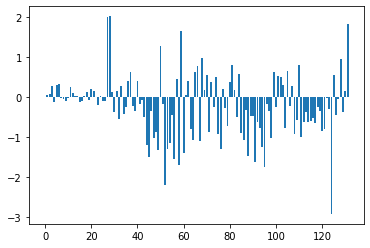

In [229]:
from sklearn.feature_selection import f_regression

feature_importance = f_regression(X_train, Y_train)

# Create DataFrame with feature importance
feature_ranking = pd.DataFrame(columns=dataset.columns[:-1], data=feature_importance, index=["f-score", "p-value"])
# Reshape DataFrame and sort by f-score
feature_ranking = feature_ranking.transpose().sort_values(["f-score", "p-value"], ascending=False)
# Create column with feature names
feature_ranking = feature_ranking.reset_index().rename(columns = {'index': 'feature'})

px.bar(feature_ranking.sort_values(["f-score", "p-value"]), x = 'f-score', y = 'feature')

from matplotlib import pyplot

importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()